0 : error=23.2963
10 : error=0.2110
20 : error=0.0138
30 : error=0.0011


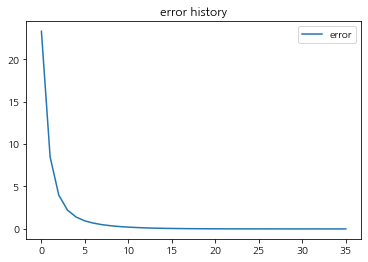


R :
[[ 4. nan nan  2. nan]
 [nan  5. nan  3.  1.]
 [nan nan  3.  4.  4.]
 [ 5.  2.  1.  2. nan]]

Estimated R :
[[4.01 4.95 4.23 2.   6.23]
 [5.67 4.97 4.47 2.98 1.02]
 [6.4  5.19 2.99 4.   3.99]
 [4.95 2.02 1.02 2.   4.72]]

F :
[[ 0.14  0.28  0.08  0.44  0.77  0.25  0.24  0.03  0.16  0.51  0.04  0.51
   0.66  0.33  0.43  0.45  0.11  0.42  0.14  0.43 -0.03  0.58  0.07  0.49
   0.01 -0.39  0.23  0.72 -0.35  0.68 -0.15 -0.12  0.19  0.19  0.54  0.2
   0.59  0.    0.33  0.8   0.94  0.56  0.5   0.91  0.37 -0.03  0.35  0.59
   0.17  0.77]
 [-0.18  0.52 -0.    0.39 -0.08  0.14  0.65  0.56 -0.18  0.64  0.12  0.16
   0.59  0.17  0.32  0.63  0.55 -0.11  0.15  0.76  0.02  0.23 -0.01  0.28
   0.03  0.56  0.59  0.73 -0.09  0.76  0.01  0.76 -0.09  0.61  0.45  0.3
   0.59  0.31  0.54 -0.02  0.33 -0.4  -0.15  0.34 -0.12  0.74 -0.06  0.39
   0.55 -0.13]
 [ 0.43  0.61 -0.3   0.57  0.33  0.59  0.78  0.55  0.4  -0.25  0.75  0.37
  -0.11 -0.19  0.    0.11  0.7   0.46  0.01  0.55  0.08  0.03  0.68  0.3
  

In [1]:
# 행렬 분해 : R = F * B
# NaN이 포함된 R이 주어졌을 때 행렬 F, B를 추정한다.
# by Stochastic Gradient Descent
# ----------------------------------------------
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

# User-item matrix
N = np.NaN
R = np.array([[4, N, N, 2, N],
              [N, 5, N, 3, 1],
              [N, N, 3, 4, 4],
              [5, 2, 1, 2, N]])

N_ROW = R.shape[0]
N_COL = R.shape[1]

@nb.jit
# SGD로 행렬 F, B를 업데이트한다.
def update_matrix(R, F, B, a, r):
    for i in range(N_ROW):
        for j in range(N_COL):
            if np.isnan(R[i, j]) != True:  # nan이 아니면
                # error 항을 계산한다.
                eij = R[i, j] - np.dot(F[i, :], B[j, :])
    
                # update F, B
                F[i, :] += a * (eij * B[j, :] - r * F[i, :])
                B[j, :] += a * (eij * F[i, :] - r * B[j, :])

@nb.jit
# NaN이 포함된 행렬의 mean_squared_error를 계산한다.
# 행렬 x에는 NaN이 포함돼 있다. y에는 없다.
def mse_skip_nan(x, y):
    mse = 0.0
    cnt = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.isnan(x[i, j]) != True:  # nan이 아니면
                mse += (x[i, j] - y[i, j]) ** 2
                cnt += 1
    return mse / cnt

# SGD로 행렬을 F, B로 분해한다.
def factorize_matrix(matR, k, max_iter=1000, alpha=0.01, beta=0.01, err_limit=1e-4):
    # F, B를 random 초기화한다.
    F = np.random.rand(N_ROW, k)  # factor matrix
    B = np.random.rand(N_COL, k)  # beta matrix.
 
    old_err = 9999   # error 초깃값
    err_hist = []    # error history
    for step in range(max_iter):
        # F, B를 업데이트한다.
        update_matrix(matR, F, B, alpha, beta)
        
        # error를 계산하고 저장해 둔다.
        err = mse_skip_nan(matR, np.dot(F, B.T))
        err_hist.append(err)

        # early stopping
        if np.abs(old_err - err) < err_limit:
            break
        
        old_err = err
        
        if step % 10 == 0:
            print('{} : error={:.4f}'.format(step, err))

    if step >= max_iter - 1:
        print('max_iter={}번 동안 stop하지 못했습니다.'.format(max_iter))
        print('max_iter를 늘리거나 err_limit을 늘려야 합니다.')
        
    return F, B.T, err_hist

K = 50  # number of factors
F, B, err = factorize_matrix(R, K)
ER = np.dot(F, B)   # estimated R

# error history를 관찰한다.
plt.plot(err, label='error')
plt.legend()
plt.title('error history')
plt.show()

print('\nR :')
print(np.round(R, 2))
print('\nEstimated R :')
print(np.round(ER, 2))   
print('\nF :')
print(np.round(F, 2))
print('\nB :')
print(np.round(B, 2))
